In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

transform = torchvision.transforms.ToTensor()


In [2]:
BATCH_SIZE=1

labeled_scene_index = np.arange(106, 134)
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
random.seed(1008)
random.shuffle(labeled_scene_index)
train_idx = labeled_scene_index[:22]
val_idx = labeled_scene_index[22:26]
test_idx = labeled_scene_index[26:]

transform = transform = torchvision.transforms.ToTensor()

train_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_idx,
                                  transform=transform,
                                  extra_info=True
                                 )

val_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_idx,
                                  transform=transform,
                                  extra_info=True
                                 )


test_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_idx,
                                  transform=transform,
                                  extra_info=True
                                 )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, 
                                          shuffle=True, num_workers=2, 
                                          collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers=2, 
                                         collate_fn = collate_fn)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers=2, 
                                          collate_fn = collate_fn)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
def dice_loss(true, preds, epsilon = 1e-4):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def dice_loss2(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)


def compute_dice(true, preds, epsilon = 1e-7):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

In [4]:
from VPN_model import PPMBilinear, vpn_model

In [42]:
data, _, roadmap, _ = iter(train_loader).next()

In [43]:
data = torch.stack(data)
target =torch.stack(roadmap)

In [44]:
data.shape

torch.Size([1, 6, 3, 256, 306])

In [45]:
target.shape

torch.Size([1, 800, 800])

In [47]:
data= data.cuda()


test_output = my_model(data)

In [48]:
test_output.shape

torch.Size([1, 1, 800, 800])

In [63]:
inputs = val_set[419][0].unsqueeze(0).to(device)

In [64]:
inputs.shape

torch.Size([1, 6, 3, 256, 306])

In [66]:
outputs = my_model(inputs)

In [69]:
outputs = outputs.squeeze().cpu().detach()

In [74]:
def train_eval_model(model, dataloaders,criterion, optimizer, 
                num_epochs, checkpoint, to_save, print_every=10, eval_every = 1, to_eval = False):
    
    start_time = time.time()
    if checkpoint:
        pt = torch.load(checkpoint)
        model.load_state_dict(pt['best_model'])
        optimizer.load_state_dict(pt['optimizer'])
        best_loss = pt['best_loss']
        print('loading weights')
    else: 
        best_loss = 1e10
    
    loss_dict = {'train':[], 'val':[]}
    dice_dict = {'train':[], 'val':[]}
    ts_dict = []
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        if (to_eval) and (epoch%eval_every == 0):
            phases = ['train', 'val']
        else:
            phases = ['train']
            
        for phase in phases:
            # print(len(dataloaders[phase]))
            
            curr_loss = 0.0
            curr_dice = 0.0
            
            
            if phase == 'train':
                model.train()

            else:
                model.eval()
                curr_ts = 0.0
                
            for i, (data, _, roadmap, _) in enumerate(dataloaders[phase]):
                inputs = torch.stack(data).to(device)
                target = torch.stack(roadmap).to(device)
                
                optimizer.zero_grad()
                if phase == 'train':
                    with torch.set_grad_enabled(phase=='train'):
                        outputs = model(inputs)
                        loss = criterion(target.cpu(), outputs.cpu().squeeze(1))
                        loss.backward()
                        optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        loss = criterion(target.cpu(), outputs.cpu().squeeze(1))
                    
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), outputs.cpu().squeeze(1))
                curr_loss += loss.item()
                curr_dice += dice_score
                if phase == 'val':
                    curr_ts += compute_ts_road_map(target.cpu(), outputs.cpu().squeeze(1))

            
            loss_dict[phase].append(curr_loss/len(dataloaders[phase]))
            dice_dict[phase].append(curr_dice/len(dataloaders[phase]))
            
            print('current epoch %s composite loss is %f'%(phase, curr_loss))
            print('current epoch %s dice coef is %f'%(phase, curr_dice))
            print('%sing 1 epoch takes %f min'%(phase, (time.time() - epoch_start)/60))
            
            if phase == 'val':
                ts_dict.append(curr_ts/len(dataloaders[phase]))
                print('current ts is %f'%(curr_ts/len(dataloaders[phase])))
                
                # val: after finishing 1 epoch
                if(curr_loss/len(dataloaders[phase])) < best_loss:
                    print('saving best model')
                    checkpt= {'best_model': model.state_dict(),
                                  'optimizer': optimizer.state_dict(), 
                                  'best_loss': curr_loss/len(dataloaders[phase])}
                    torch.save(checkpt, to_save)
                    best_loss = curr_loss/len(dataloaders[phase])
                                 
        if epoch %print_every == 0:
            print('printing test image')
            fig, ax = plt.subplots(5, 2, figsize=(15,30))
            test_idx = [173, 289, 441, 361, 9]
            for fig_i, i in enumerate(test_idx):
                inputs = val_set[i][0].unsqueeze(0).to(device)
                with torch.no_grad():
                    outputs = model(inputs).cpu().squeeze().detach()

                ax[fig_i, 0].imshow(val_set[i][2].cpu())

                ax[fig_i, 1].imshow((outputs>0.5).numpy())
            plt.show()
            
    print('This training takes ', time.time() - start_time)
    
    for key in list(loss_dict.keys()):
        if len(loss_dict[key]) > 0:
            fig = plt.figure()
            plt.plot(loss_dict[key])
            plt.title('%s Loss per epoch'%(key))
            plt.show()
    for key in list(dice_dict.keys()):
        if len(dice_dict[key]) > 0:
            fig = plt.figure()
            plt.plot(dice_dict[key])
            plt.title('%s Dice Score per epoch' %(key))
            plt.show()
    fig = plt.figure()
    plt.plot(ts_dict)
    plt.title('ts score for validation')
    plt.show()

    
    
    return model, loss_dict, dice_dict, ts_dict
    

In [6]:
class encoder_for_vae(nn.Module):

    def __init__(self):
        super(encoder_for_vae, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(2048, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.mu_dec = nn.Linear(18432, 512)
        self.logvar_dec = nn.Linear(18432, 512)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 18432)
        mu = self.mu_dec(x)
        logvar = self.logvar_dec(x)

        return mu, logvar
    
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class _DecoderBlock(nn.Module):
    """
    Taken from https://github.com/zijundeng/pytorch-semantic-segmentation/blob/master/models/seg_net.py
    """
    def __init__(self, in_channels, out_channels, num_conv_layers, out_activation = 'relu'):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)
class decoder_conv(nn.Module):
    def __init__(self):
        super(decoder_conv, self).__init__()
        self.dec1 = _DecoderBlock(128, 256,2)
        self.dec2 = _DecoderBlock(256, 256,2)
        self.dec3 = _DecoderBlock(256, 256, 2)
        self.dec4 = _DecoderBlock(256, 256, 2)
        self.dec5 = _DecoderBlock(256 ,256, 2)
        self.dec6 = _DecoderBlock(256, 128, 2)
        self.conv_out = nn.Conv2d(128, 1,3 , padding=1)
        self.final_upsample = nn.Upsample((800, 800), mode='bilinear', align_corners=False)
        self.sigmoid = nn.Sigmoid()
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)
                
    def forward(self, x):
        x = x.view(-1, 128, 2, 2)
        x = self.dec1(x)
        x= self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.dec5(x)
        x = self.dec6(x)
        x = self.conv_out(x)
        x = self.final_upsample(x)
        x = self.sigmoid(x)
        return x
class vae_mapping(nn.Module):
    def __init__(self):
        super(vae_mapping, self).__init__()
        
        self.feature_extractor = torchvision.models.resnet50(pretrained = False)
        self.encoder = [nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), 
                                 bias = False)] + list(self.feature_extractor.children())[1:-2]
        self.encoder = nn.Sequential(*self.encoder)
        self.encoder_for_vae = encoder_for_vae()
        self.decoder = decoder_conv()
        
    def reparameterize(self, is_training, mu, logvar):
        if is_training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x, is_training, defined_mu = None):
        feature_maps = self.encoder(x)
        mu, logvar = self.encoder_for_vae(feature_maps)
        z = self.reparameterize(is_training, mu, logvar)
        
        pred_map = self.decoder(z)
        
        return pred_map, mu, logvar

In [ ]:
from VAE_lane import vae_mapping

In [8]:
import copy, time

In [85]:
vae_checkpoint = torch.load('/scratch/ht1162/DLResult/vae_pretrain_lane3.pth')
vae_model = vae_mapping()
vae_model.load_state_dict(vae_checkpoint['best_model'])
vae_weights = copy.deepcopy(vae_model.decoder.dec6.state_dict())


In [86]:
decoder  =PPMBilinear(fc_dim=1024)
decoder.conv_last[1].load_state_dict(vae_weights)

<All keys matched successfully>

In [87]:

# two heads
feature_extractor = torchvision.models.resnet50(pretrained = False)
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])
feature_extractor.load_state_dict(torch.load('/scratch/bva212/dl_project/jigsaw_best_model_fe.pth'))

resnet_encoder = nn.Sequential(*list(feature_extractor.children())[:-1])

for param in resnet_encoder.parameters():
    param.requires_grad = True
for param in decoder.parameters():
    param.requires_grad = True
    


DIM1=16
DIM2=20
my_model = vpn_model(DIM1, DIM2, resnet_encoder, decoder)

optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)


In [52]:
mini_set, _ = torch.utils.data.random_split(train_set, [5, len(train_set) - 5])
mini_val, _ = torch.utils.data.random_split(val_set, [3, len(val_set)-3])

mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

In [78]:
mini_loaders = {'train': mini_loader, 'val': mini_val_loader}
dataloaders = {'train': train_loader, 'val': val_loader}

In [88]:
my_model = my_model.to(device)

Epoch 1/40
----------
current epoch train composite loss is 934.171269
current epoch train dice coef is 918.914917
training 1 epoch takes 9.121207 min
current epoch val composite loss is 173.817897
current epoch val dice coef is 165.091034
valing 1 epoch takes 9.778472 min
current ts is 0.494961
saving best model
printing test image


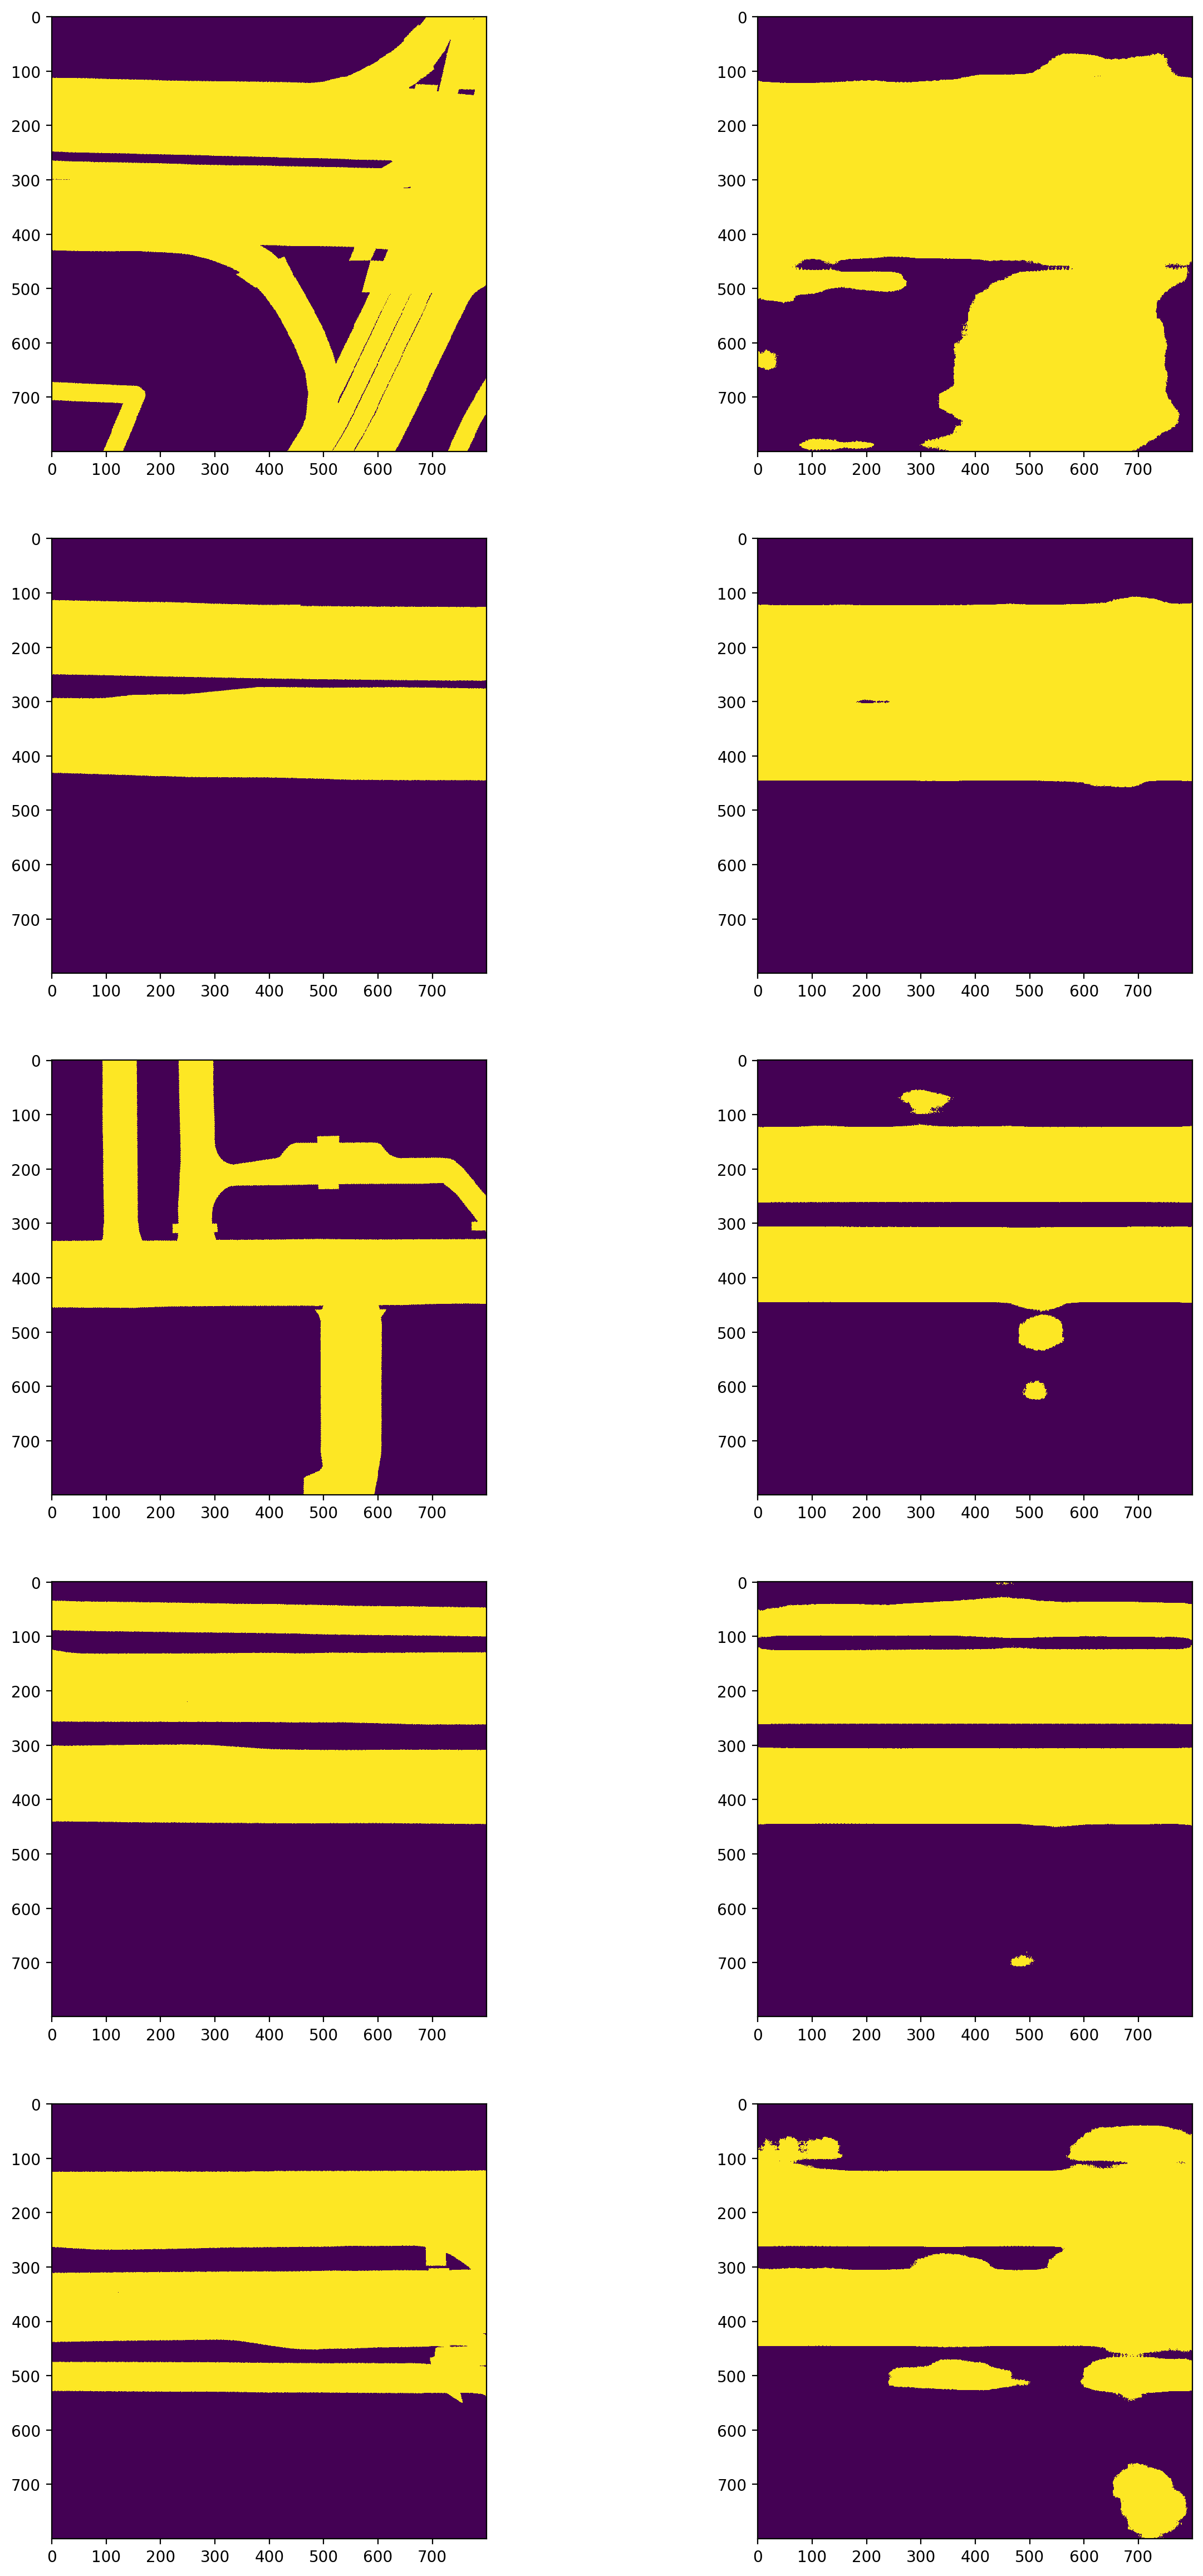

Epoch 2/40
----------
current epoch train composite loss is 759.687967
current epoch train dice coef is 1006.157166
training 1 epoch takes 9.140497 min
current epoch val composite loss is 175.858219
current epoch val dice coef is 164.070877
valing 1 epoch takes 9.756024 min
current ts is 0.489602
Epoch 3/40
----------
current epoch train composite loss is 631.806423
current epoch train dice coef is 1070.097900
training 1 epoch takes 8.893413 min
current epoch val composite loss is 151.041662
current epoch val dice coef is 176.479156
valing 1 epoch takes 9.514808 min
current ts is 0.548138
saving best model
Epoch 4/40
----------
current epoch train composite loss is 528.360145
current epoch train dice coef is 1121.819580
training 1 epoch takes 9.276306 min
current epoch val composite loss is 140.026379
current epoch val dice coef is 181.986832
valing 1 epoch takes 9.941686 min
current ts is 0.576484
saving best model
Epoch 5/40
----------
current epoch train composite loss is 441.442089

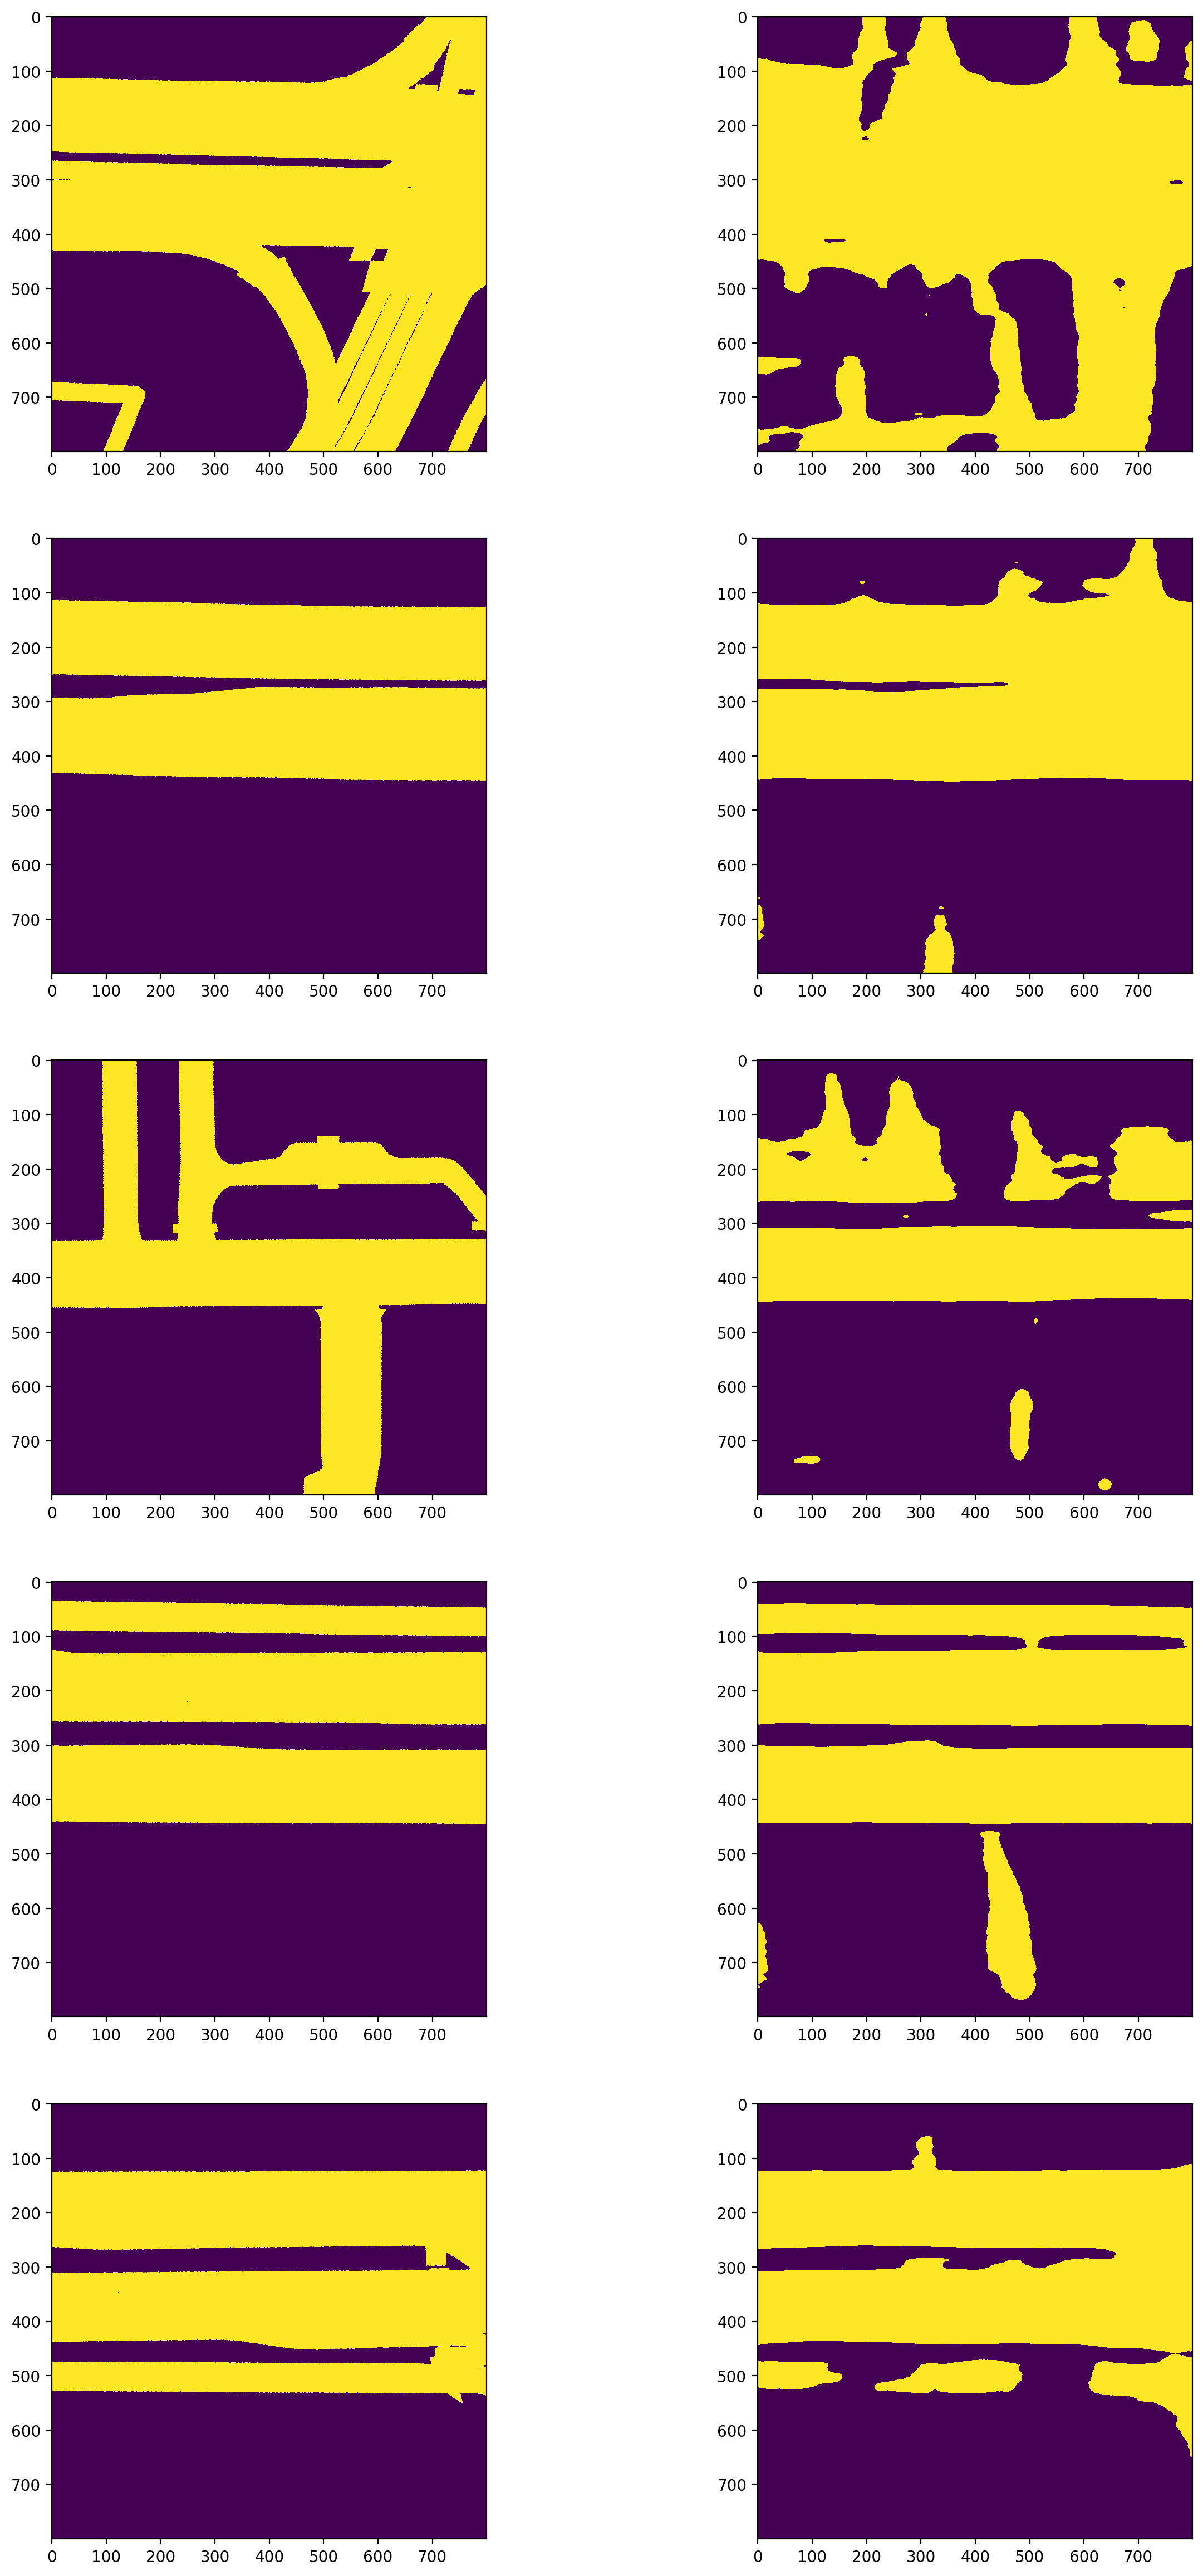

Epoch 12/40
----------
current epoch train composite loss is 145.023536
current epoch train dice coef is 1313.487549
training 1 epoch takes 9.486606 min
current epoch val composite loss is 101.232636
current epoch val dice coef is 201.383743
valing 1 epoch takes 10.223799 min
current ts is 0.685547
saving best model
Epoch 13/40
----------
current epoch train composite loss is 127.644020
current epoch train dice coef is 1322.178589
training 1 epoch takes 9.288971 min
current epoch val composite loss is 104.281913
current epoch val dice coef is 199.859070
valing 1 epoch takes 9.970517 min
current ts is 0.676467
Epoch 14/40
----------
current epoch train composite loss is 114.053240
current epoch train dice coef is 1328.974487
training 1 epoch takes 9.037852 min
current epoch val composite loss is 100.217511
current epoch val dice coef is 201.891174
valing 1 epoch takes 9.718970 min
current ts is 0.688650
saving best model
Epoch 15/40
----------
current epoch train composite loss is 102.5

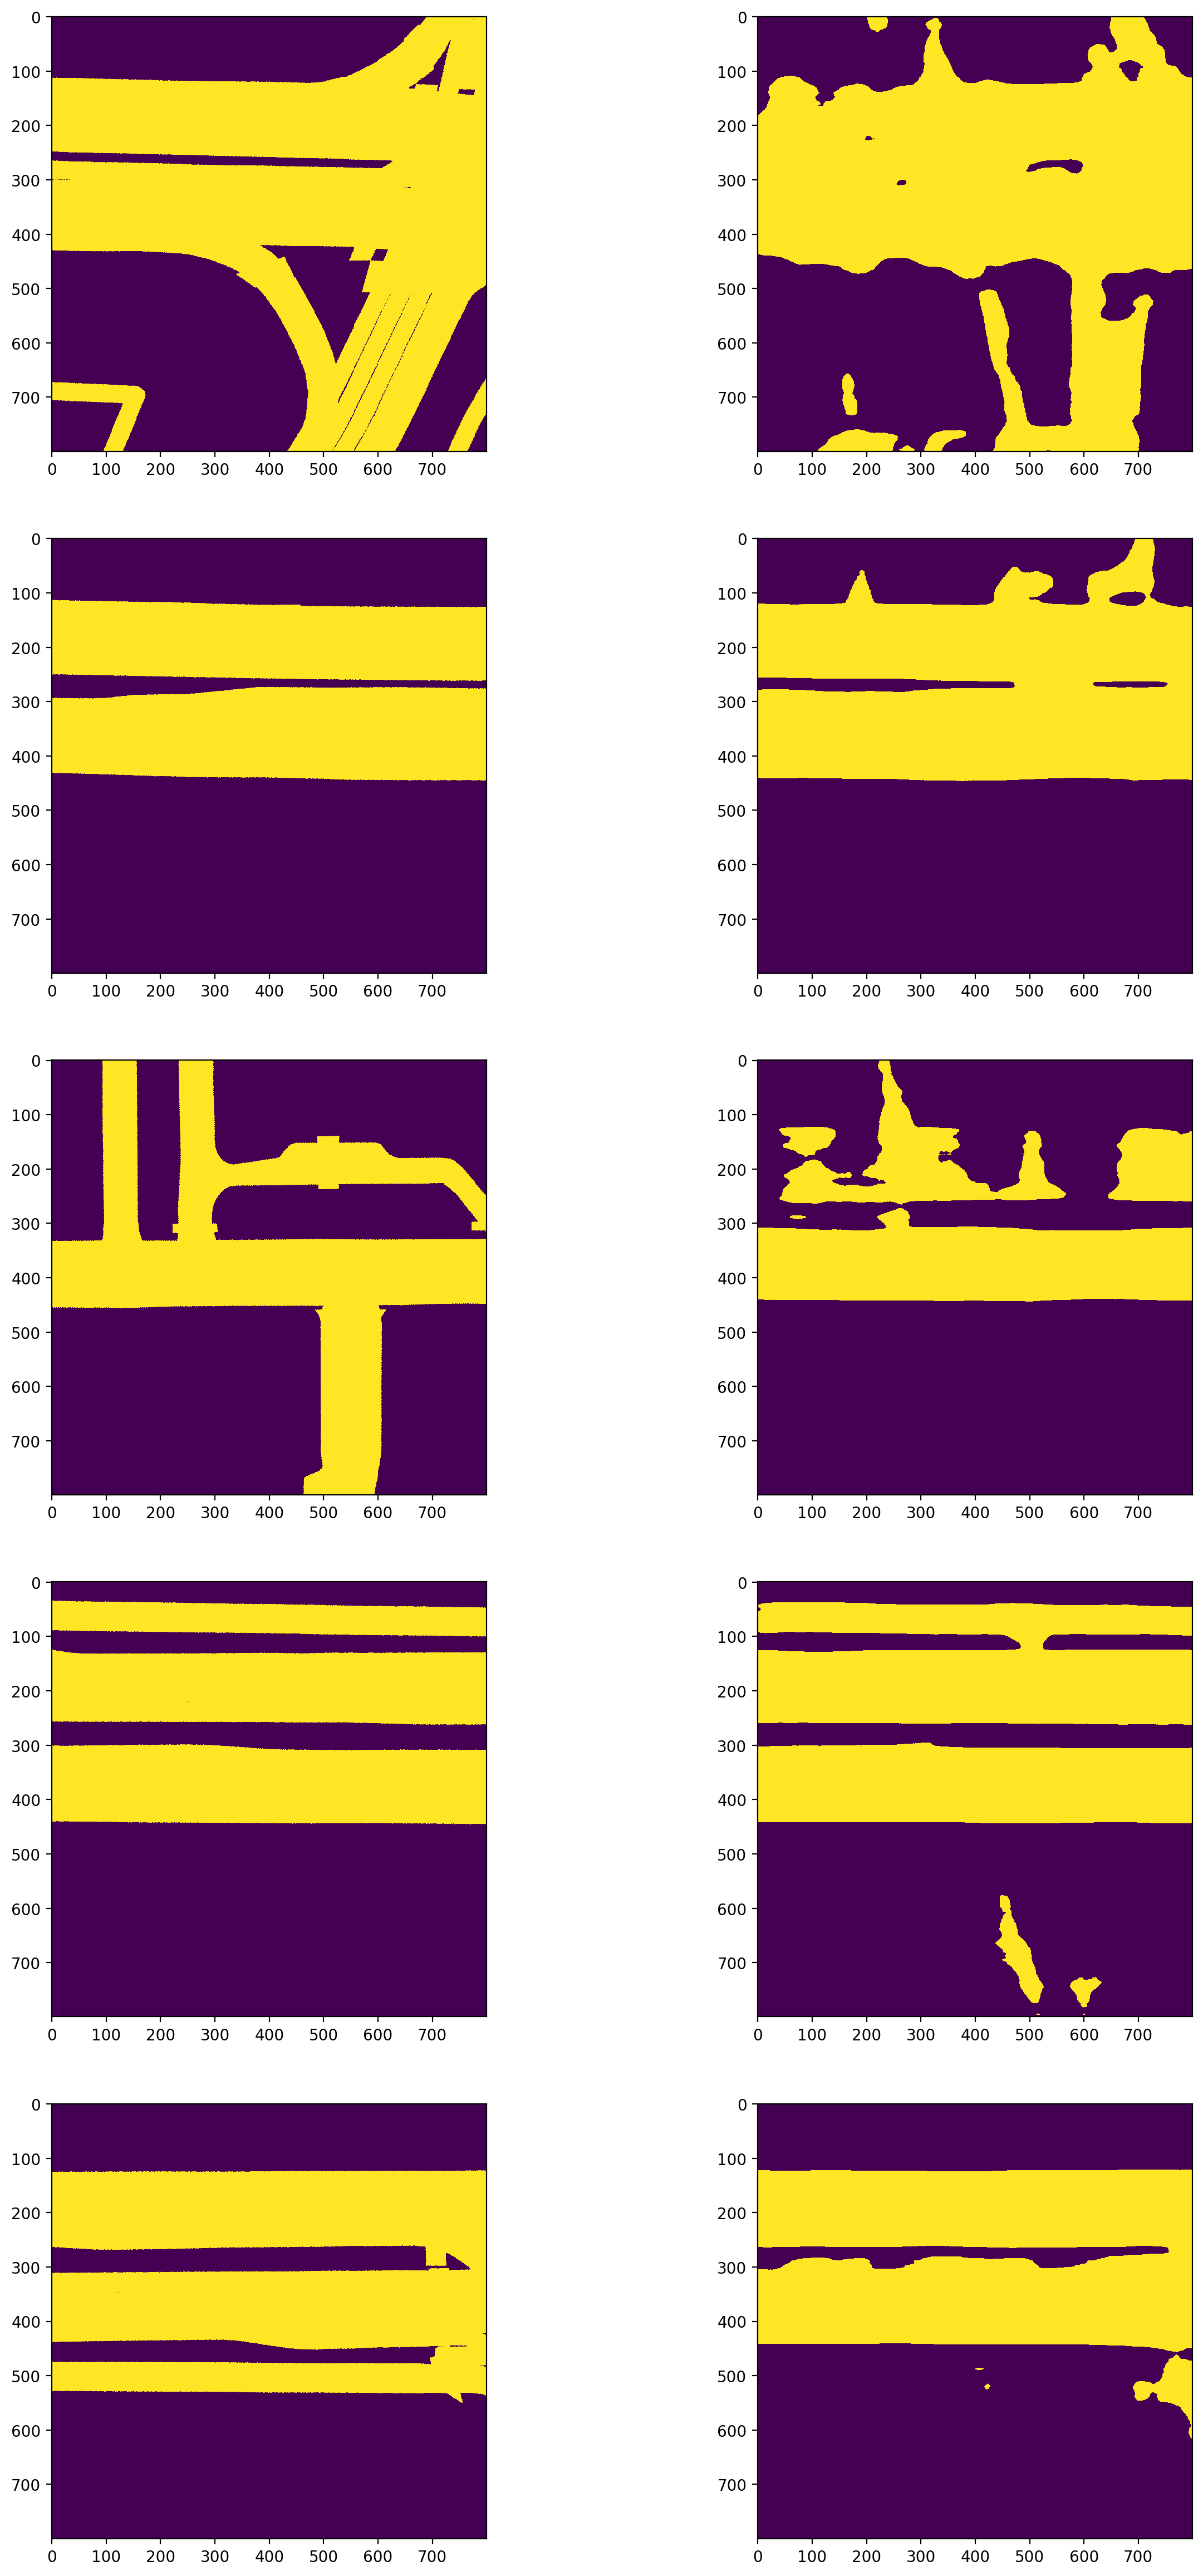

Epoch 22/40
----------
current epoch train composite loss is 60.641344
current epoch train dice coef is 1355.677979
training 1 epoch takes 8.683193 min
current epoch val composite loss is 104.850561
current epoch val dice coef is 199.574829
valing 1 epoch takes 9.338188 min
current ts is 0.680171
Epoch 23/40
----------
current epoch train composite loss is 57.462323
current epoch train dice coef is 1357.268799
training 1 epoch takes 8.674453 min
current epoch val composite loss is 91.059134
current epoch val dice coef is 206.470352
valing 1 epoch takes 9.316231 min
current ts is 0.715708
Epoch 24/40
----------
current epoch train composite loss is 55.096291
current epoch train dice coef is 1358.452393
training 1 epoch takes 8.700498 min
current epoch val composite loss is 91.738032
current epoch val dice coef is 206.130844
valing 1 epoch takes 9.358384 min
current ts is 0.713603
Epoch 25/40
----------
current epoch train composite loss is 52.738543
current epoch train dice coef is 1359

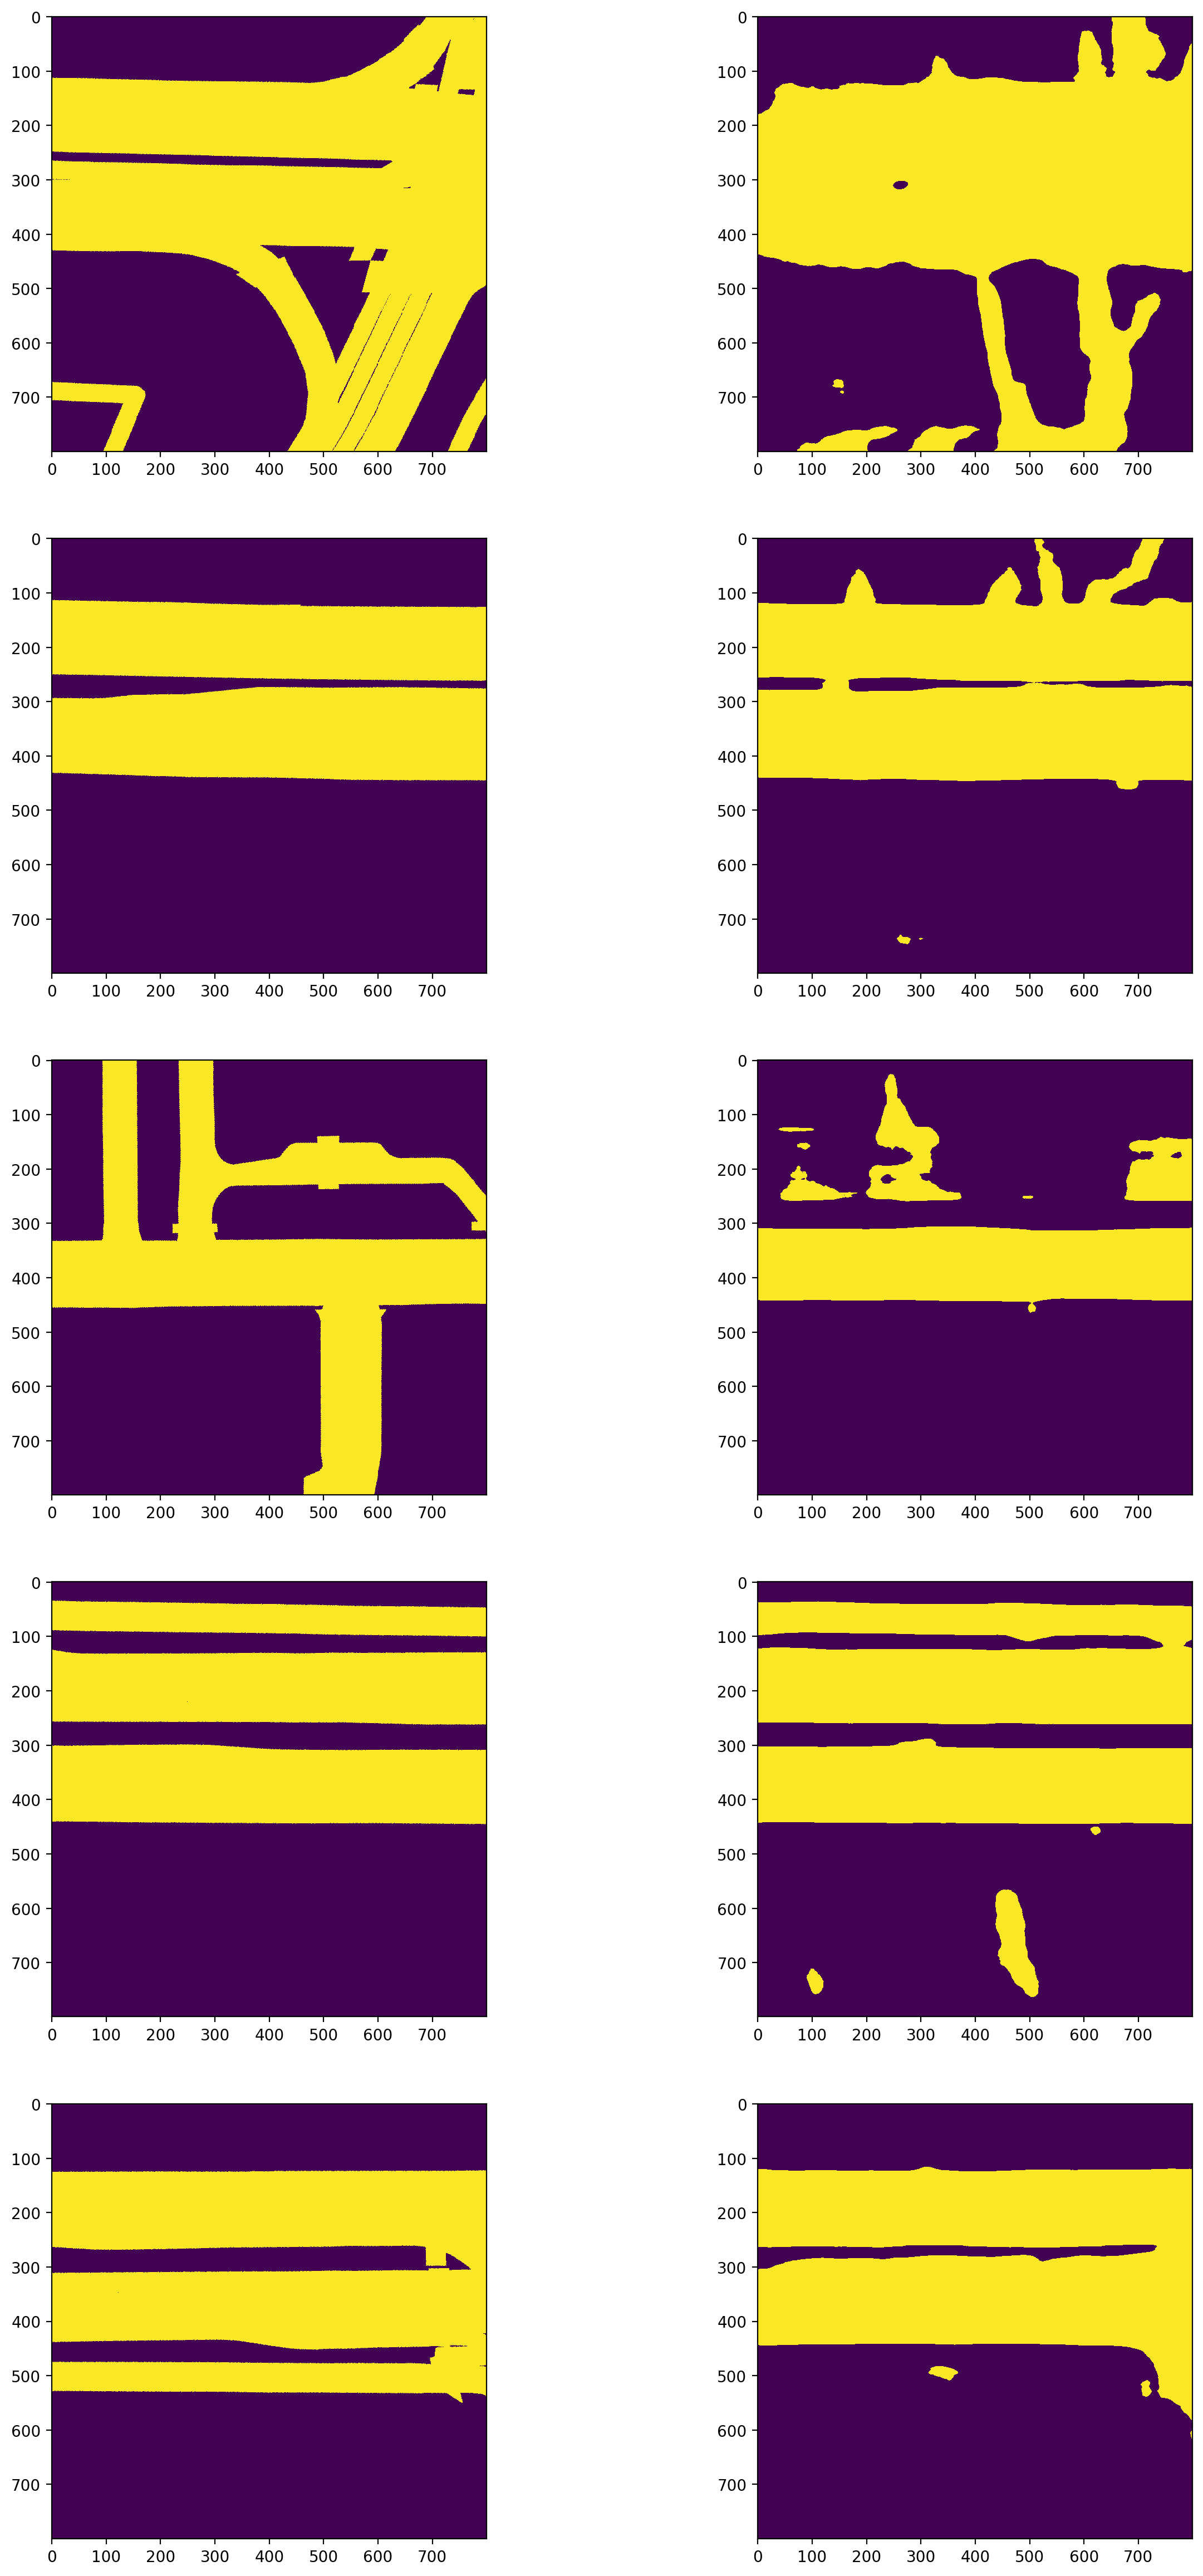

Epoch 32/40
----------
current epoch train composite loss is 42.623685
current epoch train dice coef is 1364.687744
training 1 epoch takes 9.658951 min
current epoch val composite loss is 96.128679
current epoch val dice coef is 203.935638
valing 1 epoch takes 10.251228 min
current ts is 0.700560
Epoch 33/40
----------
current epoch train composite loss is 41.852164
current epoch train dice coef is 1365.072876
training 1 epoch takes 9.408409 min
current epoch val composite loss is 93.725401
current epoch val dice coef is 205.137283
valing 1 epoch takes 10.011909 min
current ts is 0.708262
Epoch 34/40
----------
current epoch train composite loss is 40.941423
current epoch train dice coef is 1365.529785
training 1 epoch takes 9.425236 min
current epoch val composite loss is 96.689132
current epoch val dice coef is 203.655441
valing 1 epoch takes 10.051242 min
current ts is 0.700636
Epoch 35/40
----------
current epoch train composite loss is 40.191863
current epoch train dice coef is 13

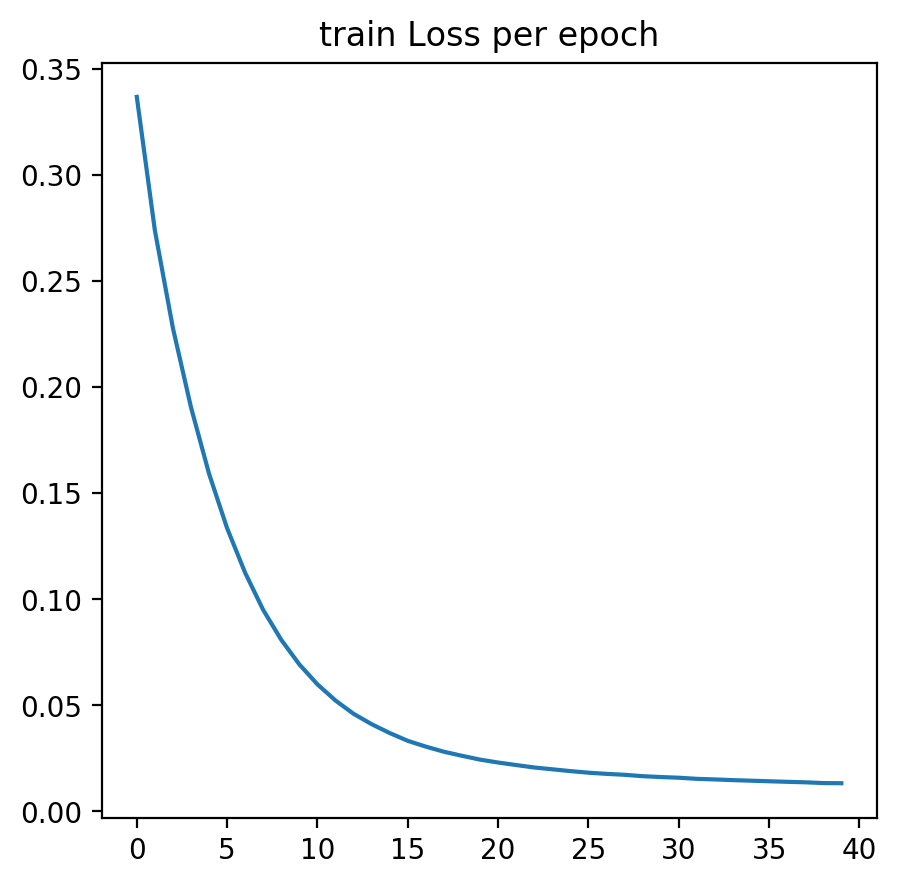

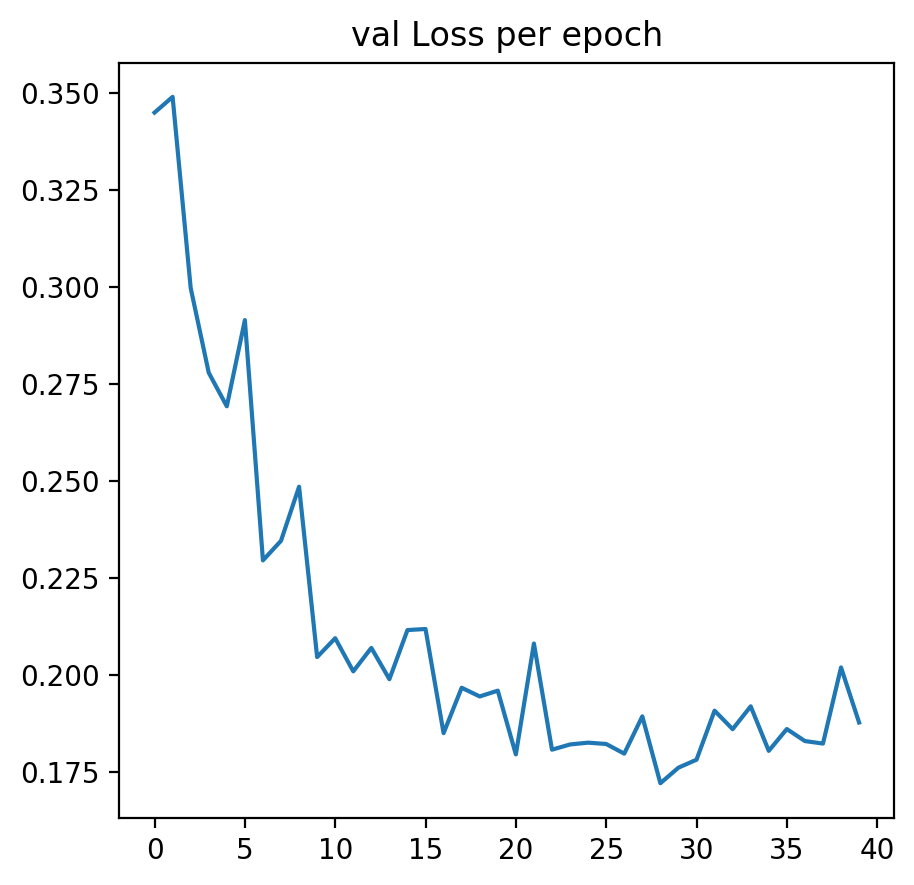

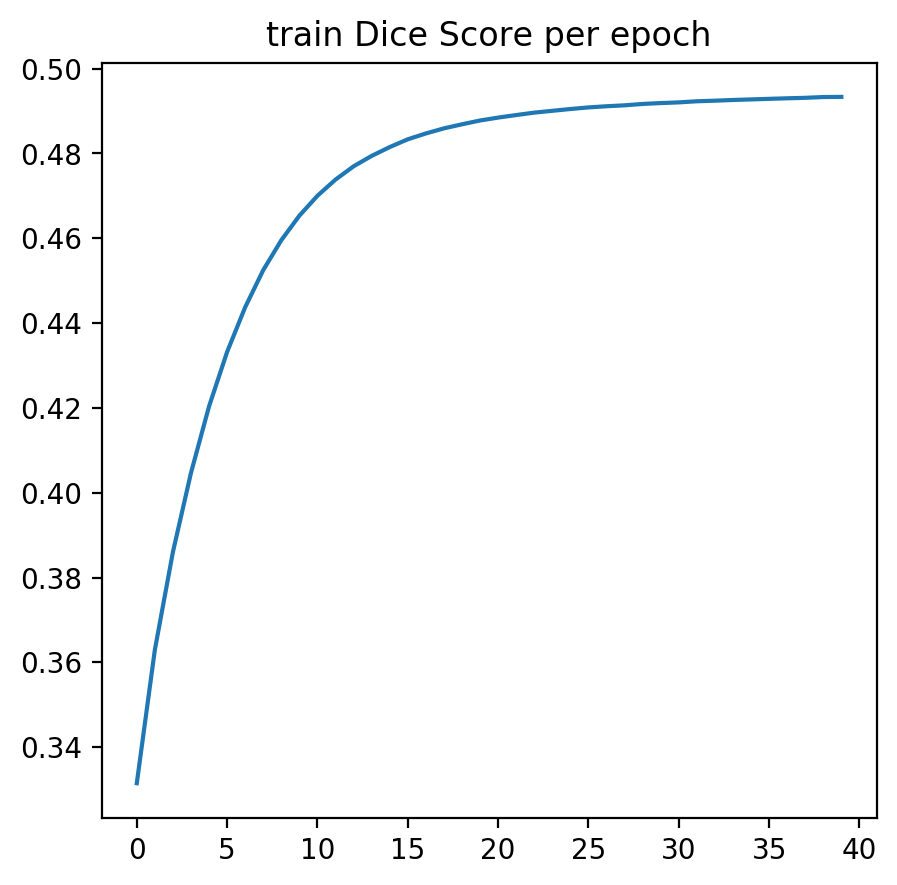

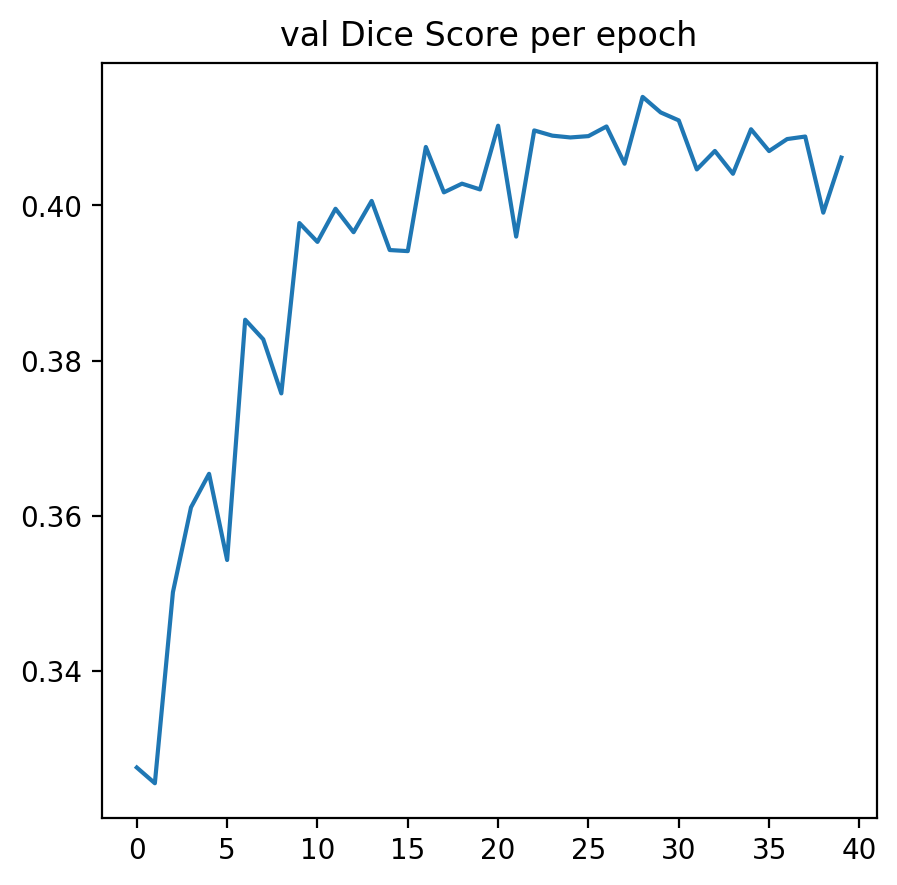

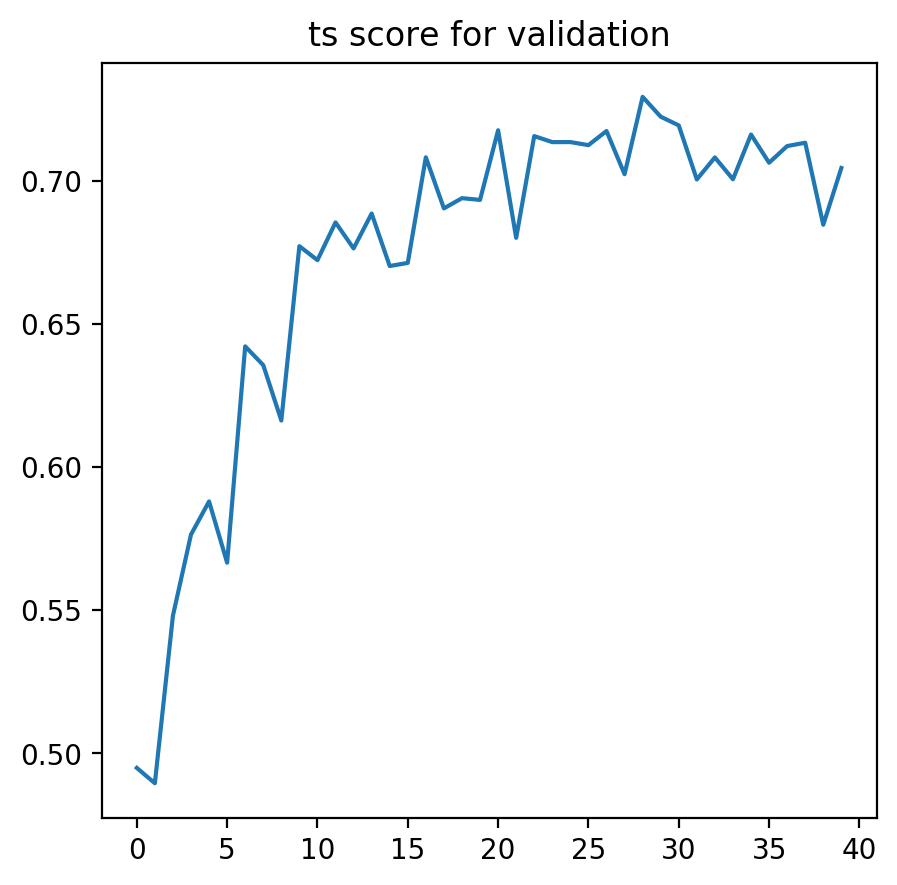

In [89]:
model, loss_dict, dice_dict, ts_dict = train_eval_model(my_model, dataloaders, 
                                                        dice_loss, optimizer, 
                                                        num_epochs=40, checkpoint=None, 
                                                        to_save = '/scratch/ht1162/DLResult/jigsaw_resnet50_w_vae.pth', 
                                                        print_every=10, 
                                                        eval_every = 1, to_eval = True)